In [1]:
import pandas as pd
import seaborn as sns
import new_utils
import new_plots
import glob
import os

import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [3]:
u2os_files = glob.glob("../data/U2OS/*.xlsx")
u2os_files

['../data/U2OS/NAD_raw_2.xlsx', '../data/U2OS/NAD_raw_1.xlsx']

## Estimate growth rate

In [4]:
def iso_correction(files, met='NAD', xcol='time', threshold=0.01,
                   growth_correction=False, transform=None, 
                   columns=['cell type', 'time', 'replicate number'],
                   cell_column='cell type'):
    df_isocorr = pd.DataFrame()
    for file in files:
        df_raw = pd.read_excel(file)
        df_raw['time'] = df_raw['time point (h)']
        _df_isocorr = new_utils.get_iso_corr(df_raw=df_raw, met=met, xcol=xcol, threshold=threshold,
                                             growth_correction=growth_correction, transform=transform,
                                             columns=columns, cell_column=cell_column)
        df_isocorr = pd.concat([df_isocorr, _df_isocorr])
    return df_isocorr


df_isocorr = iso_correction(files=u2os_files)
df_isocorr

,cell type,replicate number,time,NAD,NAD_10C13,NAD_10C13_O18,NAD_5C13,NAD_5C13_O18,NAD_O18
0,U2OS wt,1,0,1.134519e+06,0.000000,0.000000,0.000000,0.000000,0.000000
1,U2OS wt,2,0,1.024323e+06,0.000000,0.000000,0.000000,0.000000,0.000000
2,U2OS wt,3,0,8.702622e+05,0.000000,0.000000,0.000000,0.000000,0.000000
15,U2OS wt,1,1,7.279619e+05,0.000000,0.000000,0.000000,12938.243038,0.000000
16,U2OS wt,2,1,7.026319e+05,0.000000,0.000000,434.881734,12150.669445,0.000000
...,...,...,...,...,...,...,...,...,...
88,U2OS erP,2,12,1.329019e+04,0.000000,21145.632078,0.000000,30296.736711,0.000000
89,U2OS erP,3,12,1.379632e+04,0.000000,31774.228278,11585.382609,12772.670492,4976.753476
102,U2OS erP,1,24,1.736007e+03,0.000000,73494.094257,0.000000,6917.150868,0.000000
103,U2OS erP,2,24,0.000000e+00,0.000000,72100.622383,2173.496538,7279.913499,0.000000


cell line: U2OS  |  met: NAD  |  threshold: 0.1


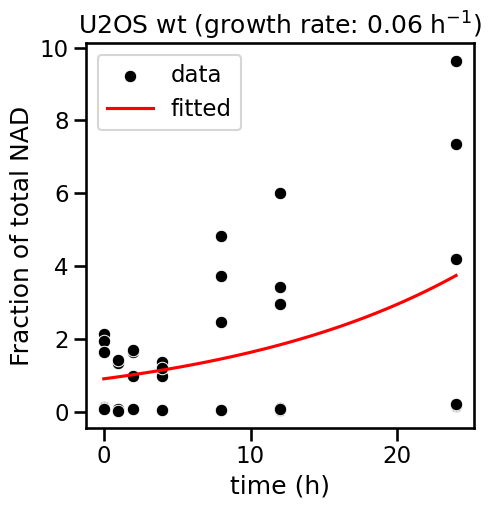

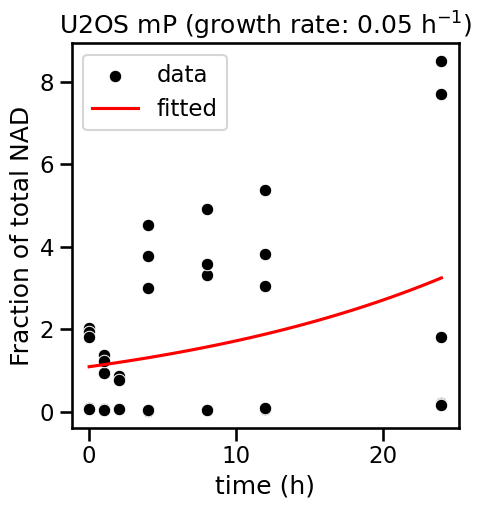

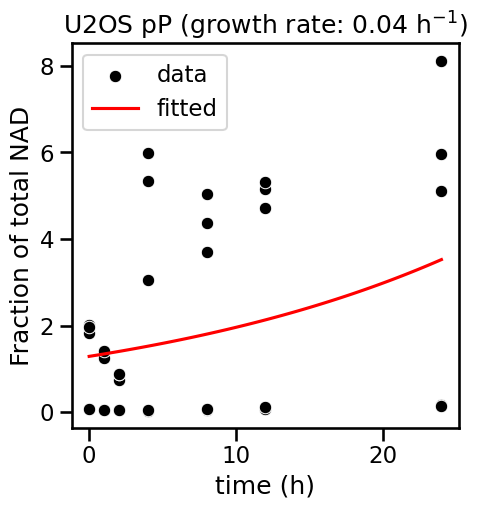

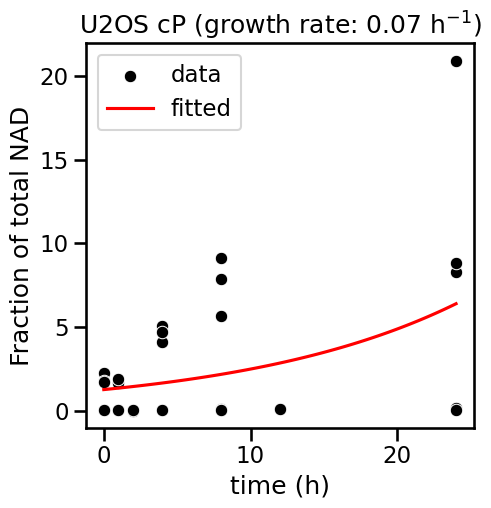

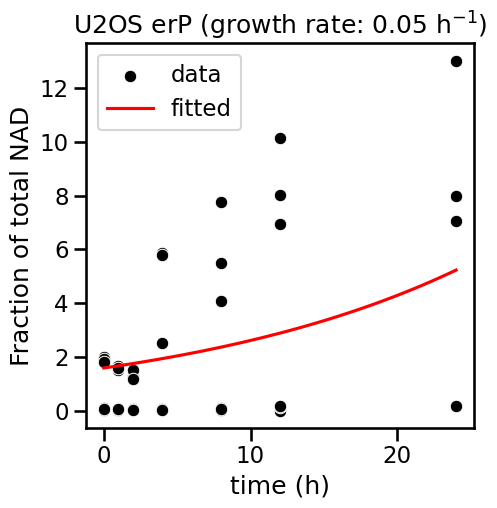

In [5]:
sns.set_context('talk', font_scale=1.0)
met = 'NAD'
threshold = 0.1
cell_line = 'U2OS'
print(f'cell line: {cell_line}  |  met: {met}  |  threshold: {threshold}')
growth_correction = False

iso_corr_all = iso_correction(files=u2os_files, met=met, threshold=threshold,
                              growth_correction=growth_correction, transform=None)
list_of_mets = [i for i in iso_corr_all.columns if i.split('_')[0] == met]
gpars = new_utils.estimate_growth_parameters(iso_corr_all, list_of_mets=list_of_mets, 
                                             cell_line=cell_line, met=met)

## NAD decay plots

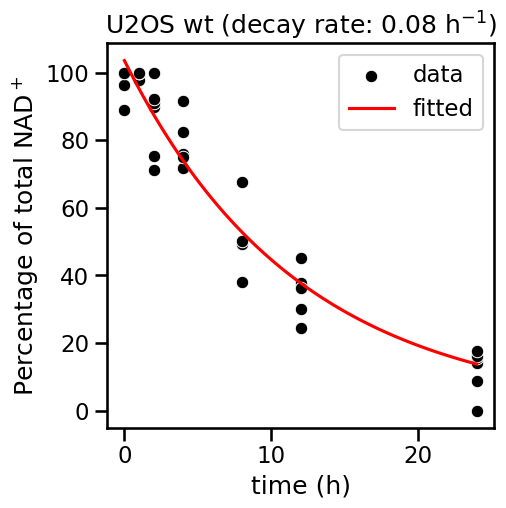

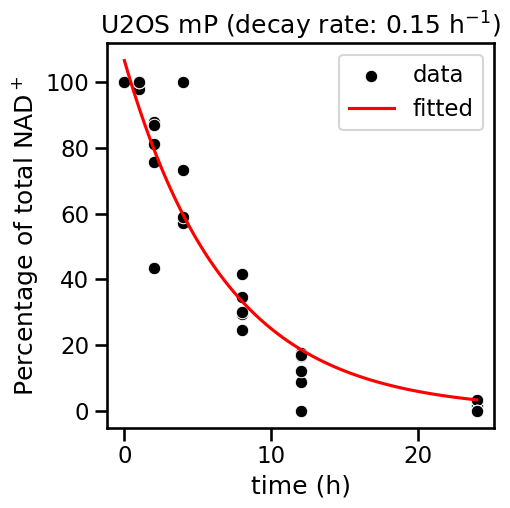

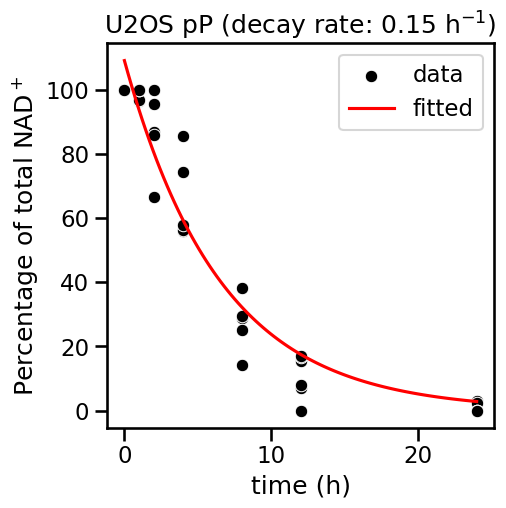

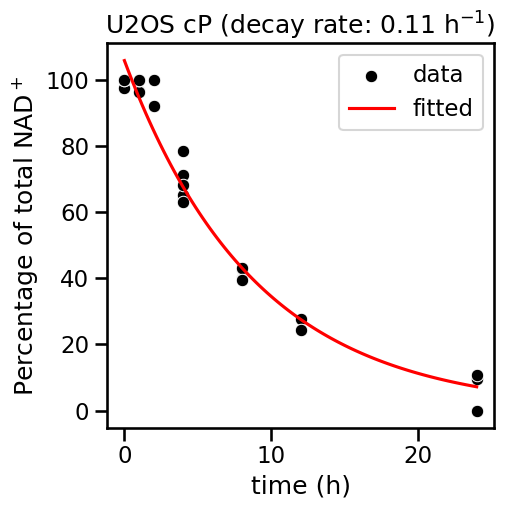

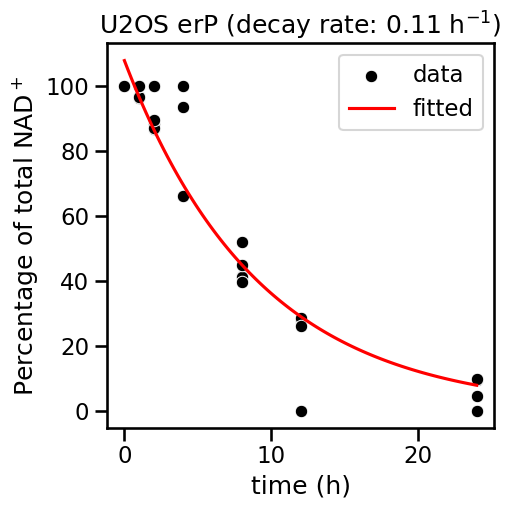

In [6]:
# Estimate decay parameters
sns.set_context('talk', font_scale=1.0)

cell_line = 'U2OS'
met = 'NAD'
save_data = False
save_fig = False
show_fig = True
growth_correction = True

all_data = iso_correction(files=u2os_files, met=met, threshold=threshold,
                          growth_correction=growth_correction, transform='percent')
list_of_mets = [i for i in all_data.columns if i.split('_')[0] == met]
dpars = new_utils.estimate_decay_parameters(iso_corr_percent=all_data, cell_line=cell_line, 
                                            xcol='time', ycol=met)

## Fig S3: Percentage labelled and unlabelled individual plots

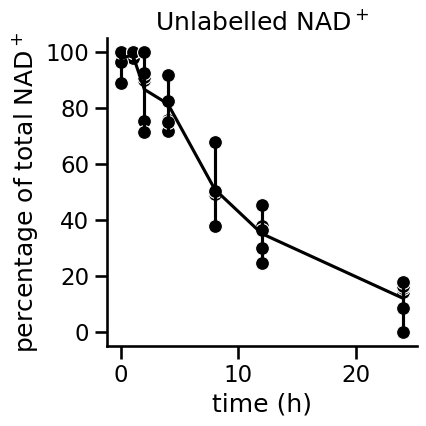

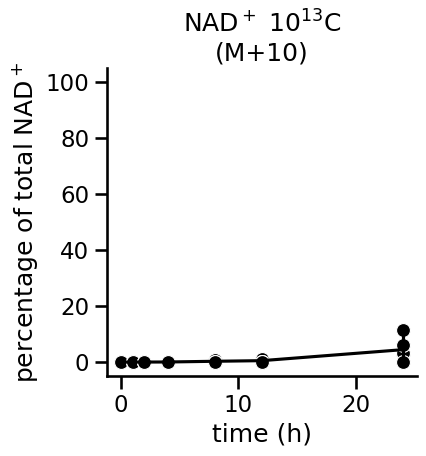

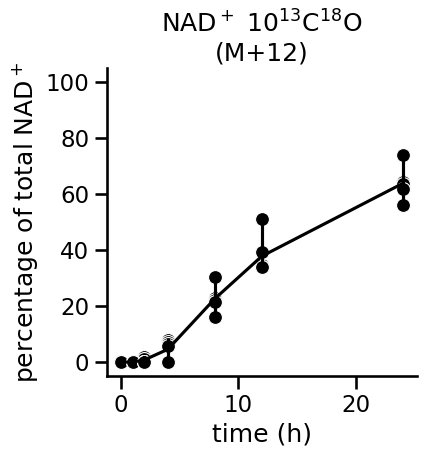

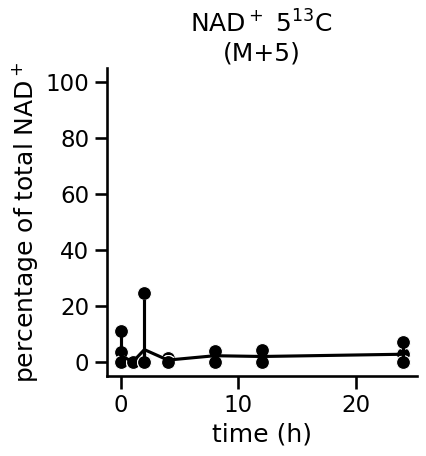

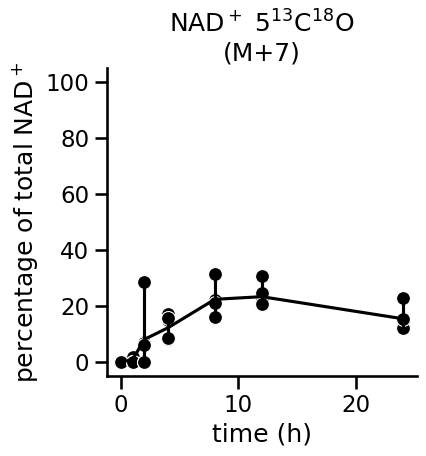

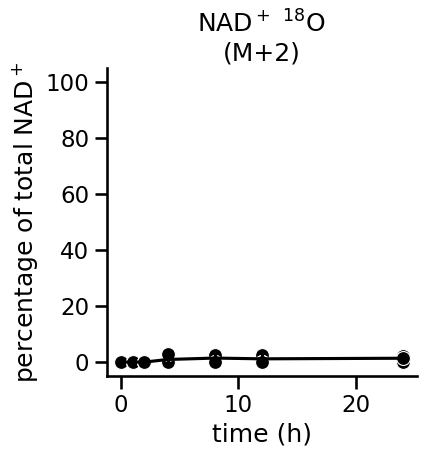

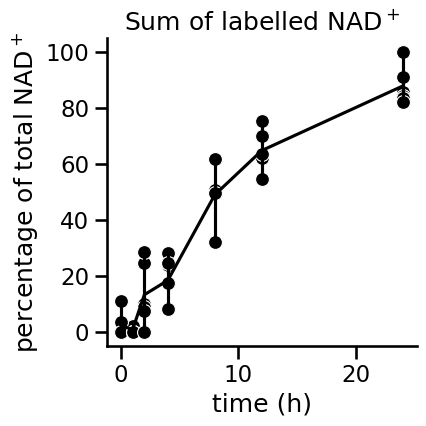

In [10]:
sns.set_context('talk', font_scale=1.0)

cell_line = 'U2OS'
met = 'NAD'
show_fig = True
save_fig = False
save_data = False
growth_correction = True

all_data = iso_correction(files=u2os_files, met=met, threshold=threshold,
                          growth_correction=growth_correction, transform='percent')
list_of_mets = [i for i in all_data.columns if i.split('_')[0] == met]
all_data['sum labelled'] = all_data[list_of_mets[1:]].sum(axis=1)
_df = all_data[all_data['cell type'] == cell_line + ' wt']
new_plots.plot_fig3_panel_b(iso_corr_percent=_df, list_of_mets=list_of_mets, 
                            cell_line=cell_line, met=met, 
                            growth_correction=growth_correction)

## Fig S3e: Unlabelled and sum labelled components plot

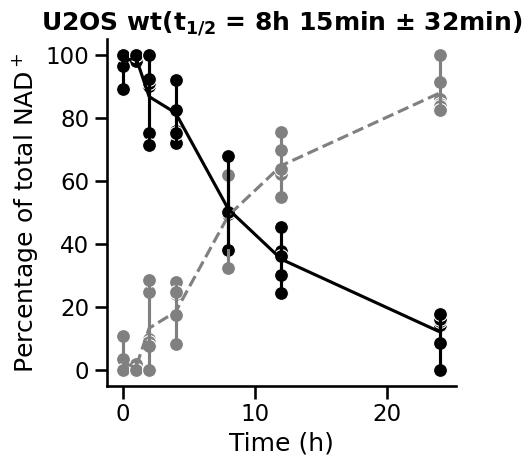

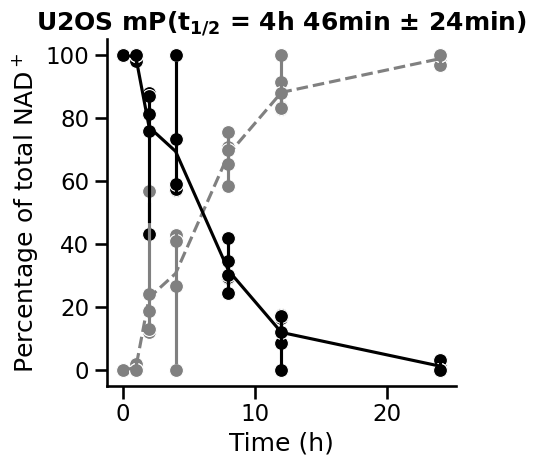

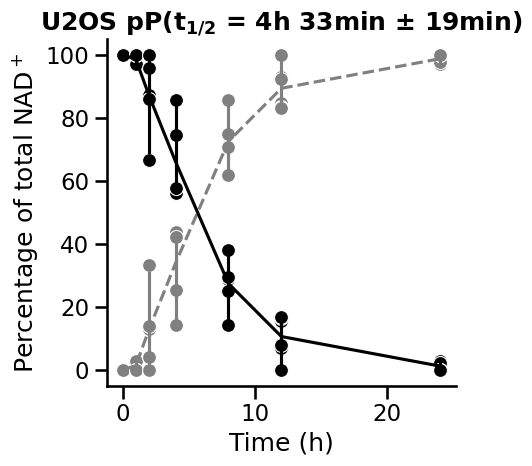

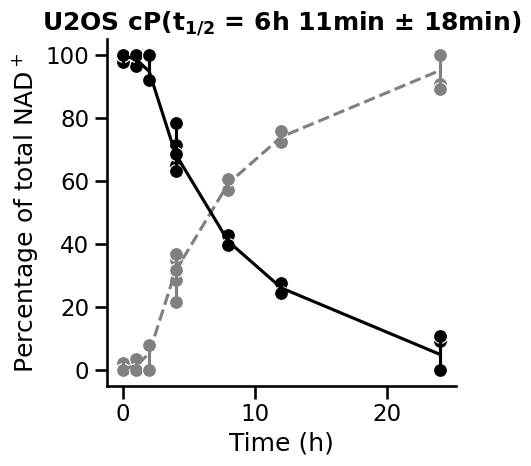

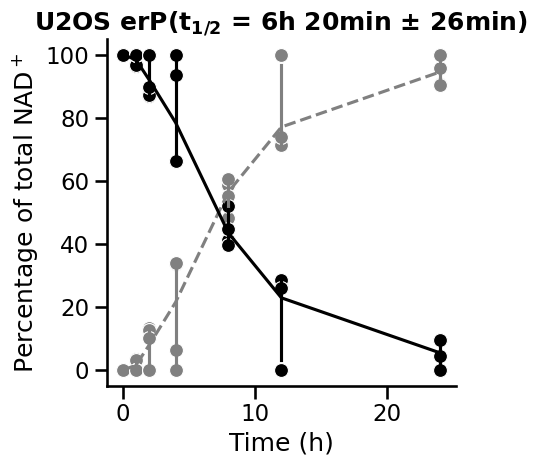

In [11]:
sns.set_context('talk', font_scale=1.0)

cell_line = 'U2OS'
met = 'NAD'
growth_correction = True

all_data = iso_correction(files=u2os_files, met=met, threshold=threshold,
                          growth_correction=growth_correction, transform='percent')
list_of_mets = [i for i in all_data.columns if i.split('_')[0] == met]
all_data['sum labelled'] = all_data[list_of_mets[1:]].sum(axis=1)
dpars = new_utils.unlabelled_and_sum_labelled(iso_corr_percent=all_data, cell_line=cell_line, xcol='time', ycol2=met,
                                              ycol='sum labelled', growth_correction=growth_correction, met=met,
                                              ylabel=f'Percentage of total NAD$^+$')

## Turnover estimation

In [16]:
{i:i.split(' ')[-1] for i in all_data['cell type'].unique()}

{'U2OS wt': 'wt',
 'U2OS mP': 'mP',
 'U2OS pP': 'pP',
 'U2OS cP': 'cP',
 'U2OS erP': 'erP'}

,t-statistic,p-value
U2OS_cP,0.419900,0.685609
U2OS_erP,0.333424,0.747385
U2OS_mP,2.102231,0.068699
U2OS_pP,1.173959,0.274173
cP_erP,0.108242,0.916469
cP_mP,1.368881,0.208235
cP_pP,0.575921,0.580504
erP_mP,1.605473,0.147057
erP_pP,0.750162,0.474639
mP_pP,0.884734,0.402108


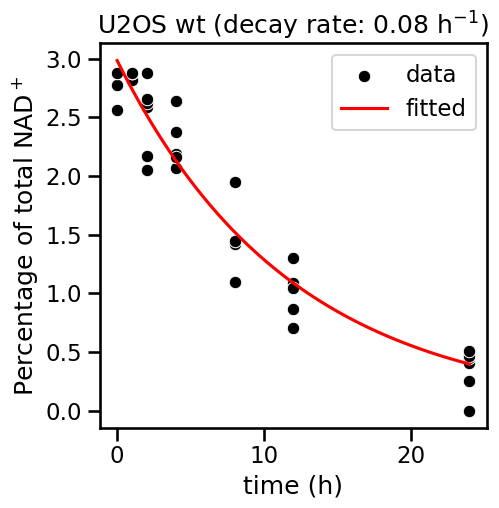

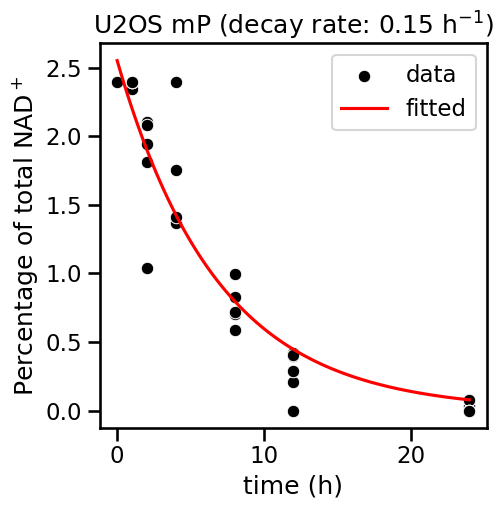

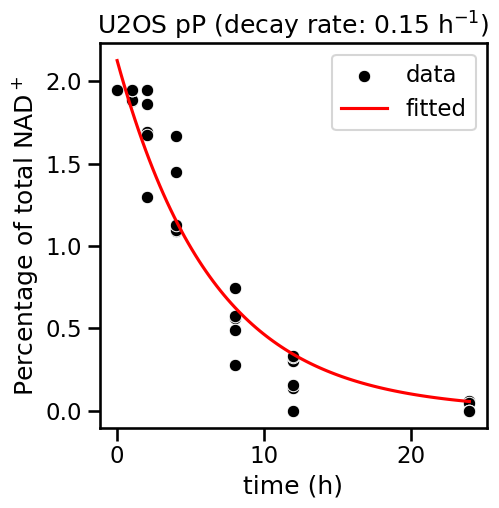

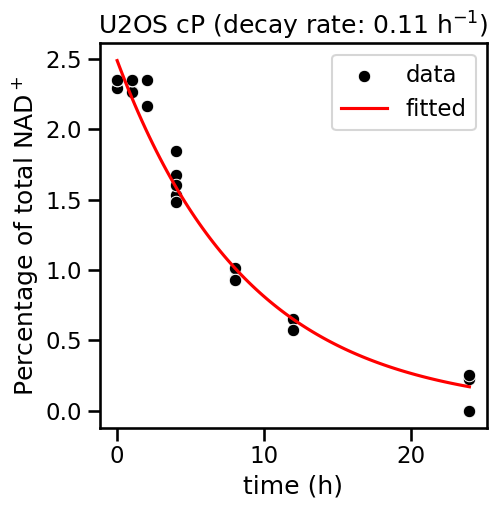

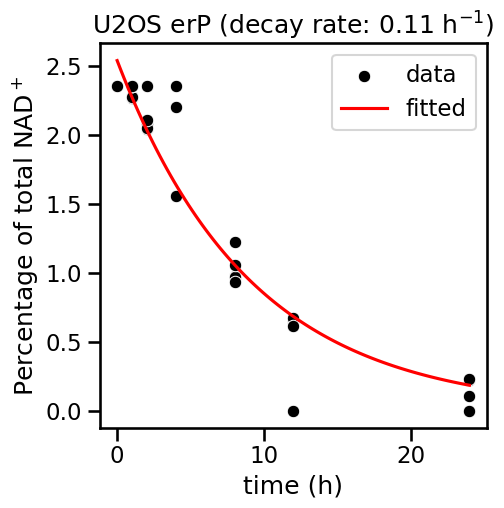

In [17]:
growth_correction = True
cell_line = 'U2OS'

all_data = iso_correction(files=u2os_files, met='NAD', threshold=0.1,
                          growth_correction=growth_correction, transform='percent')
list_of_mets = [i for i in all_data.columns if i.split('_')[0] == 'NAD']
all_data['sum labelled'] = all_data[list_of_mets[1:]].sum(axis=1)
all_data['cell type'] = all_data['cell type'].map({'U2OS wt': 'U2OS',
                                                   'U2OS mP': 'mP',
                                                   'U2OS pP': 'pP',
                                                   'U2OS cP': 'cP',
                                                   'U2OS erP': 'erP'})

nad_conc = pd.read_csv('../data/nad_conc_new.csv', index_col=0)
nad_conc = nad_conc[nad_conc['cell line'] == cell_line]
dpars = new_utils.estimate_turnover(iso_corr_percent=all_data, nad_conc=nad_conc, cell_line=cell_line,
                                    xcol='time', ycol='pool_corr_unlabelled',
                                    default_path='./publication/', save_data=False,
                                    file=None, per_experiment=False, growth_correction=growth_correction)
df_stat = new_utils.calculate_t_stats(dpars, n_samples=9)
df_stat

In [18]:
dpars

,cell type,growth_rate,growth_rate_standard_error,prefactor_growth,prefactor_growth_standard_error,prefactor_decay,decay_rate,prefactor_decay_error,decay_error,half_life,half_life_error,poolsize,poolsize_sd,turnover,turnover_error
0,U2OS,0.056041,0.008517,0.708490,0.117365,2.984691,0.084084,0.065634,0.005494,8.243467,0.538604,2.880000,0.497594,0.174684,0.041785
1,cP,0.043084,0.010834,1.210044,0.278907,2.487378,0.112002,0.042564,0.005498,6.188728,0.303787,2.350000,0.564004,0.189861,0.066652
2,erP,0.048682,0.008647,1.189232,0.195344,2.537033,0.109408,0.063163,0.007509,6.335450,0.434841,2.350000,0.537773,0.185464,0.055213
3,mP,0.053219,0.009285,0.805632,0.144112,2.551873,0.145224,0.079474,0.011932,4.772962,0.392152,2.393333,0.438900,0.250718,0.066720
4,pP,0.047396,0.007113,0.966599,0.130107,2.125654,0.152290,0.056714,0.010656,4.551509,0.318464,1.946667,0.421584,0.213849,0.058299
